## CS22B1093

______________

## Data Preparation

In [156]:
import pandas as pd
import numpy as np
anime_df = pd.read_csv("anime.csv")
print(anime_df.head())
rating_df = pd.read_csv("rating.csv")
print(rating_df.head())

   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  
   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4

In [157]:
rating_df.replace(-1,'NaN',inplace=True)
rating_df

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [158]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [159]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [160]:
anime_df.duplicated().sum()

0

In [161]:
rating_df.duplicated().sum()

1

In [162]:
rating_df = rating_df.drop_duplicates()

In [163]:
unique_anime = len(anime_df.anime_id.unique())
print(unique_anime)

12294


In [164]:
unique_userid = len(rating_df.user_id.unique())
print(unique_userid)

73515


In [165]:
rating_df = rating_df.copy()
rating_df.replace(-1, np.nan, inplace=True)
rating_df.drop_duplicates(inplace=True)

In [166]:
anime_df['genre'] = anime_df['genre'].fillna('')
anime_df['type'] = anime_df['type'].fillna('Unknown')

______________

## Content Based Filtering Using KNN Clustering

In [167]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelBinarizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [168]:
# One-hot encode the genre column
anime_df['genre'] = anime_df['genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(anime_df['genre']), columns=mlb.classes_, index=anime_df.index)

# One-hot encode the 'type' column (TV, Movie, OVA, etc.)
type_binarizer = LabelBinarizer()
type_encoded = pd.DataFrame(type_binarizer.fit_transform(anime_df['type']), columns=type_binarizer.classes_, index=anime_df.index)

# Concatenate genre-encoded and type-encoded features back to the original anime dataframe
anime_features = pd.concat([anime_df, genre_encoded, type_encoded], axis=1)

# Drop non-numerical columns and any other columns not needed for KNN
anime_features_clean = anime_features.drop(['anime_id', 'name', 'genre', 'type'], axis=1)

# Convert all remaining features to numeric (if they aren't already)
anime_features_clean = anime_features_clean.apply(pd.to_numeric, errors='coerce')

# Check for any remaining NaN values and handle them (e.g., by filling with a number or dropping)
anime_features_clean = anime_features_clean.fillna(0)

In [169]:
# Normalize the anime features
scaler = StandardScaler()
anime_features_normalized = scaler.fit_transform(anime_features_clean)

# Fit the KNN models on the anime features with different metrics
knn_euclidean = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='euclidean')
knn_manhattan = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='manhattan')
knn_cosine = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine')

knn_euclidean.fit(anime_features_normalized)
knn_manhattan.fit(anime_features_normalized)
knn_cosine.fit(anime_features_normalized)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [170]:
# Function to recommend animes based on user's ratings
def recommend_animes(user_id, knn_model, n_recommendations=5):
    user_ratings = rating_df[rating_df['user_id'] == user_id]
    user_anime_ids = user_ratings['anime_id'].values
    user_anime_features = anime_features_normalized[anime_df['anime_id'].isin(user_anime_ids)]
    
    if len(user_anime_features) == 0:
        return pd.DataFrame()
    
    # Calculate the mean of the user's anime features correctly
    user_anime_features_mean = user_anime_features.mean(axis=0).reshape(1, -1)
    
    # Find the nearest neighbors for the user's mean anime features
    distances, indices = knn_model.kneighbors(user_anime_features_mean, n_neighbors=n_recommendations)
    
    # Get the anime IDs of the nearest neighbors
    recommended_anime_ids = anime_df.iloc[indices[0]]['anime_id'].values
    
    return anime_df[anime_df['anime_id'].isin(recommended_anime_ids)][['anime_id', 'name', 'genre', 'type', 'rating']]

In [171]:
# Function to calculate RMSE for recommendations
def calculate_rmse(user_id, recommendations):
    user_ratings = rating_df[rating_df['user_id'] == user_id]
    user_anime_ids = user_ratings['anime_id'].values
    user_ratings_dict = user_ratings.set_index('anime_id')['rating'].to_dict()
    
    recommended_ratings = [user_ratings_dict.get(anime_id, np.nan) for anime_id in recommendations['anime_id']]
    recommended_ratings = [rating for rating in recommended_ratings if not np.isnan(rating)]
    
    if len(recommended_ratings) == 0:
        return float('inf')
    
    rmse = np.sqrt(mean_squared_error([user_ratings_dict[anime_id] for anime_id in recommendations['anime_id'] if anime_id in user_ratings_dict], recommended_ratings))
    return rmse

In [172]:
# Plotting the clusters using PCA for dimensionality reduction
def plot_knn_clusters(user_id):
    pca = PCA(n_components=2)
    anime_features_pca = pca.fit_transform(anime_features_normalized)

    # Function to plot KNN clusters
    def plot_knn_clusters(knn_model, title):
        user_ratings = rating_df[rating_df['user_id'] == user_id]
        user_anime_ids = user_ratings['anime_id'].values
        user_anime_features = anime_features_normalized[anime_df['anime_id'].isin(user_anime_ids)]
        user_anime_features_mean = user_anime_features.mean(axis=0).reshape(1, -1)
        
        distances, indices = knn_model.kneighbors(user_anime_features_mean, n_neighbors=10)
        nearest_neighbors = anime_features_pca[indices[0]]
        
        plt.scatter(anime_features_pca[:, 0], anime_features_pca[:, 1], s=10, label='All Animes')
        plt.scatter(nearest_neighbors[:, 0], nearest_neighbors[:, 1], s=50, c='red', label='Nearest Neighbors')
        plt.scatter(user_anime_features_mean[:, 0], user_anime_features_mean[:, 1], s=100, c='blue', label='User Mean')
        plt.title(title)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()

    plt.figure(figsize=(18, 6))

    # Plot for Euclidean
    plt.subplot(1, 3, 1)
    plot_knn_clusters(knn_euclidean, 'KNN Clusters (Euclidean)')

    # Plot for Manhattan
    plt.subplot(1, 3, 2)
    plot_knn_clusters(knn_manhattan, 'KNN Clusters (Manhattan)')

    # Plot for Cosine
    plt.subplot(1, 3, 3)
    plot_knn_clusters(knn_cosine, 'KNN Clusters (Cosine)')

    plt.tight_layout()

___________________

## Driver Code


1. Count Users
2. Count Anime
3. Display Movie Name
4. Recommend Movie
5. Exit


Final 5 Recommended Animes:
     anime_id                                               name  \
184      7674                                           Bakuman.   
210     16067                                    Nagi no Asukara   
262     23289                           Gekkan Shoujo Nozaki-kun   
401     14813  Yahari Ore no Seishun Love Comedy wa Machigatt...   
708     28121  Dungeon ni Deai wo Motomeru no wa Machigatteir...   

                                             genre type  rating  
184                     [Comedy, Romance, Shounen]   TV    8.35  
210                      [Drama, Fantasy, Romance]   TV    8.32  
262                      [Comedy, Romance, School]   TV    8.24  
401               [Comedy, Drama, Romance, School]   TV    8.12  
708  [Action, Adventure, Comedy, Fantasy, Romance]   TV    7.88  

1. Count Users
2. Count Anime
3. Display Movie Name
4. Recommend Movie
5. Exit

Exit

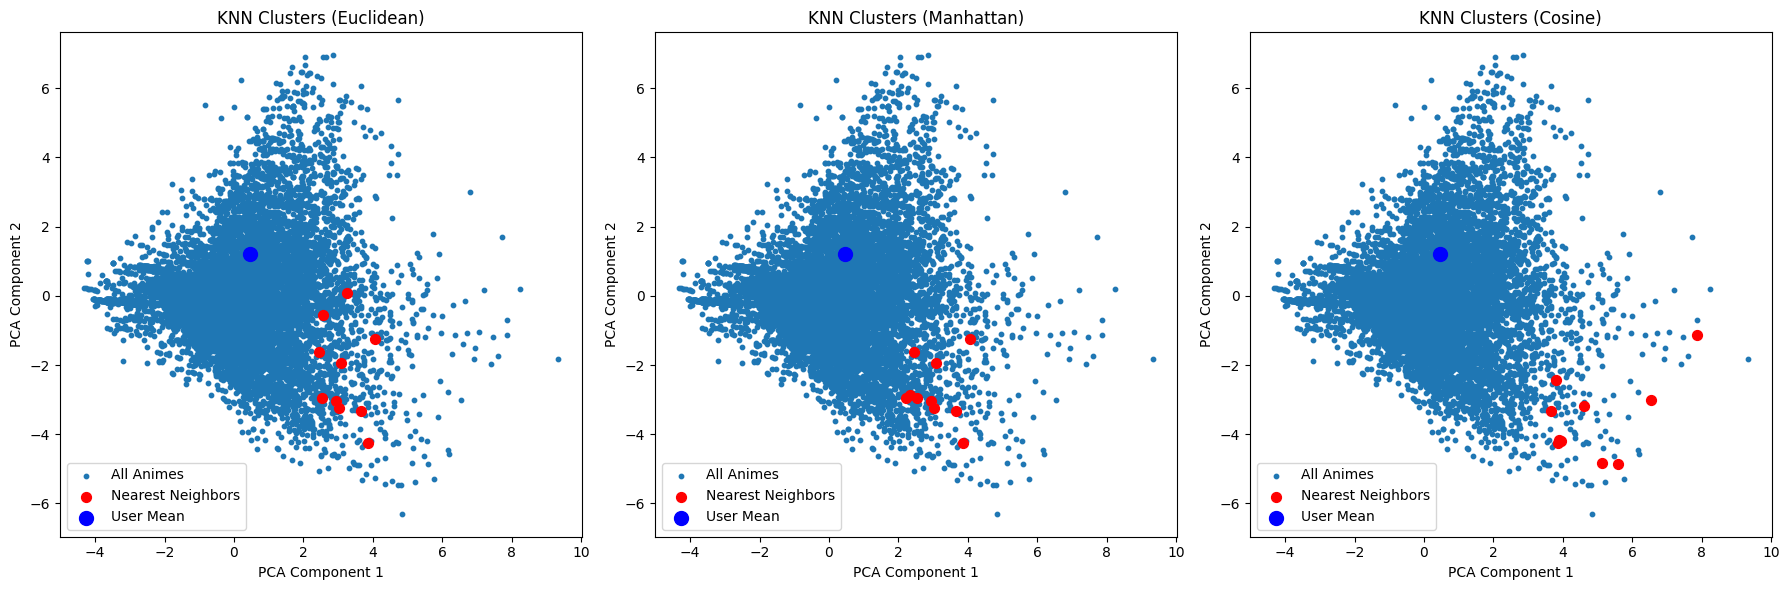

In [174]:
while True:
    print("\n1. Count Users\n2. Count Anime\n3. Display Movie Name\n4. Recommend Movie\n5. Exit\n")
    choice = int(input("Choose one of the following options: "))

    if choice == 1:
        print(f"The number of unique users in the dataset is: {unique_userid}")
    elif choice == 2:
        print(f"The number of unique movie titles in the dataset is: {unique_anime}")
    elif choice == 3:
        ani_id = int(input("Enter the anime ID: "))
        anime_name = anime_df[anime_df.anime_id == ani_id]
        if not anime_name.empty:
            print(f"The name of the movie is: {anime_name.iloc[0]['name']}")
        else:
            print(f"No movie found with Movie ID {ani_id}")
    elif choice == 4:
        user_id = int(input("Enter the user ID: "))
        recommendations_euclidean = recommend_animes(user_id, knn_euclidean)
        # recommendations_manhattan = recommend_animes(user_id, knn_manhattan)
        # recommendations_cosine = recommend_animes(user_id, knn_cosine)

        best_recommendations = recommendations_euclidean

        # Print the final 5 recommended animes in the form of a DataFrame
        print("\nFinal 5 Recommended Animes:")
        print(best_recommendations)
        plot_knn_clusters(user_id)
        
    elif choice == 5:
        print("Exiting...")
        break
    else:
        print("Invalid Choice")
        continue

_________